# Selecting Stack Thicknesses That Optimize Boost Factor

Note that we should ultimately see that d1/n1=d2/n2=wavelength/2 where wavelength is the wavelength that we are most interested in. Although if we have a complex QE for our sensor as a function of wavelength this may shift

## 1: Imports and Plotting Decisions

In [1]:
# local scripts
import boost # all functions to compute the stack thicknesses and boost spectrum
import optimization as opt # all functions to optimize the stack

# numerical computing
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import scipy.constants as const
from scipy.stats import norm
from numpy.linalg import multi_dot



# utilities
from time import time
from copy import deepcopy
import sys

# plotting
from matplotlib import pyplot as plt,colors
import seaborn as sns
from sympy.solvers import solve
from sympy import Symbol
from sympy import limit,oo


SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
FIGSIZE = (10,8)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# 2: Information About the Refractive Indices and Layers

In [2]:
n1 = 1.4656 # SiO2
n2 = 2.0218 # Si3N4
d1 = 275e-9 # 10nm
d2 = d1 * (n1/n2)
nlayers = 10
chirp1 = 1
chirp2 = 1.5
chirp3 = 2


mirror = False

In [3]:
print(805/(2*n1))
print(805/(2*n2))

274.63155021834064
199.08002769809082


# 3: Showing Boost Factors  for Different Numbers of Layers at Fixed Thicknesses

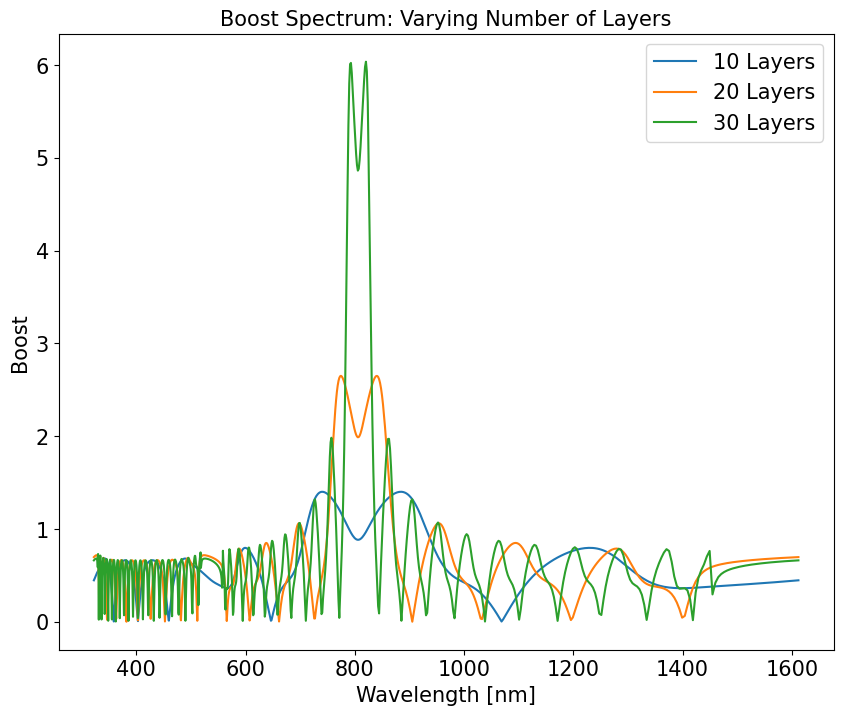

In [4]:
f1,boost1 = boost.solution_rightwave(n1,n2,d1,nLayers=10)
f2,boost2 = boost.solution_rightwave(n1,n2,d1,nLayers=20)
f3,boost3 = boost.solution_rightwave(n1,n2,d1,nLayers=46)

w1 = boost.freq_to_lamda(f1)
w2 = boost.freq_to_lamda(f2)
w3 = boost.freq_to_lamda(f3)


plt.figure(figsize=(10,8))

plt.plot(w1,boost1,label="10 Layers")
plt.plot(w2,boost2,label="20 Layers")
plt.plot(w3,boost3,label="30 Layers")

plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Boost")
plt.title("Boost Spectrum: Varying Number of Layers")
plt.show()


# 4: Creating a Dummy Sensor Quantum Efficiency
We pick a gaussian distribution centered around 805nm with width 50nm. The overall scaling of this will not effect the optimization

In [5]:
qeX=np.arange(400,1100,0.1)
qeY=norm.pdf(qeX,805,50)
qeY=qeY/np.max(qeY)

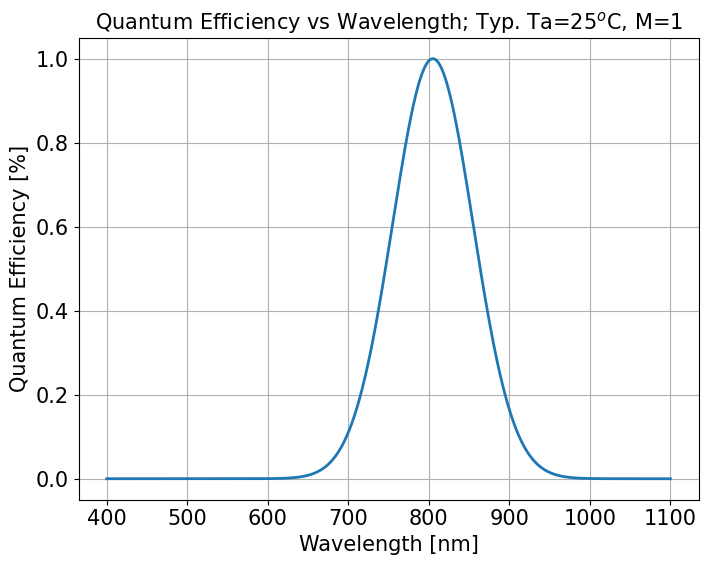

In [6]:
plt.figure(figsize=(8,6))
plt.plot(qeX,qeY,linewidth=2)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Quantum Efficiency [%]")
plt.title("Quantum Efficiency vs Wavelength; Typ. Ta=25$^o$C, M=1")
plt.grid()
plt.show()
## Data extracted from figure in https://www.hamamatsu.com/resources/pdf/ssd/s12426_series_kapd1047e.pdf using WebPlotDigitizer; 
##averaging window algorithm, deltaX=5, deltaY=5

# 5: Make some functions to get boost factors and integrate them with the QE accross a range of stack conditions

In [7]:
#Gets weighted integral of boost factor accross range of d1 for fixed d2 and number of layers
def get_integral_for_d1range(n1,n2,d1min,d1max,layers,mirr=False):
    dList=np.linspace(d1min,d1max,50)
    maxBoostList=[]
    integralList=[]
    for d1 in dList:
        w,sol=boost.solution_rightwave(n1,n2,d1,layers,mirror=mirr)
        wave=boost.freq_to_lamda(w)
        integral, x,y,wx= opt.weighted_integral(wave,np.array(sol),qeX,qeY)
        integralList.append(integral)
        maxBoostList.append(max(sol))
    return dList,np.array(maxBoostList),np.array(integralList)

In [8]:
#Gets weighted integral of boost factor accross range of d1 and number of layers for fixed d2 
def get_integral_for_nLayer_d1_range(n1,n2,d1min,d1max,layersmin,layersmax,mirr=False):
    layerList=np.arange(layersmin,layersmax+1,2)
    layerDList=[]
    layerBoostList=[]
    layerIntegralList=[]
    for layer in layerList:
        d,boost,integral=get_integral_for_d1range(n1,n2,d1min,d1max,layer,mirr=mirr)
        layerDList.append(d)
        layerBoostList.append(boost)
        layerIntegralList.append(integral)
    return(layerList,layerDList,layerBoostList,layerIntegralList)

In [9]:
#Gets weighted integral of boost factor accross range of d1 and d2 for fixed number of layers
def get_integral_for_d1d2range(n1,n2,d1min,d1max,d2min,d2max,layers,mirr=False):
    d1List=np.linspace(d1min,d1max,21)
    d2List=np.linspace(d2min,d2max,21)
    maxBoostList=[]
    integralList=[]
    for d1 in d1List:
        maxBoostD1List=[]
        integralD1List=[]
        for d2 in d2List:
            w,sol=solution_rightwave_arbitraryd2(n1,n2,d1,d2,layers,mirror=mirr)
            wave=boost.freq_to_lamda(w)
            integral, x,y,wx= opt.weighted_integral(wave,np.array(sol),qeX,qeY)
            integralD1List.append(integral)
            maxBoostD1List.append(max(sol))
        integralList.append(integralD1List)
        maxBoostList.append(maxBoostD1List)
    return d1List,d2List,np.array(maxBoostList),np.array(integralList)

# 6: Check how the boost varies with changing number of layers and d1 for fixed d2=d1*n1/n2 

In [ ]:
layers,ds,boosts,integrals=get_integral_for_nLayer_d1_range(n1,n2,250e-9,299e-9,40,60,mirr=True)

/Users/isaacsarnoff/Documents/SchoolStuff/Graduate/Fourth Year/Haloscope/haloscope/Analysis/boost-error-optimization/boost.py:21: RuntimeWarning: overflow encountered in double_scalars
  factor=0.5*((1/(n2**2))-(1/(n1**2)))


In [ ]:
cmap = plt.cm.jet
norm = colors.Normalize(vmin=40, vmax=60)

for i in range(0,len(ds)):
    figure=plt.plot(ds[i]/1e-9,integrals[i],color=cmap(norm(layers[i])))
plt.title("Integrated Boost Factors for Varying Number of Layers Assuming Gaussian QE With 50nm Width at 805nm")
plt.xlabel("d1 Thickness [nm] (d2 fixed to d1*n1/n2)")
plt.ylabel("Integrated Boost Factor [Arbitrary Units*nm]")
plt.legend(layers)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
print((ds[1])/1e-9)
for i in range(0,len(layers)):
    print(str(layers[i])+" Layers is maximized at : "+ str(ds[1][np.argmax(integrals[i])]/1e-9)+ " nm")

# 6: Check how the boost varies with changing d1 and d2 with fixed number of layers

In [ ]:
def solution_rightwave_arbitraryd2(n1,n2,d1,d2,nLayers,chirp=0,mirror=False,isTList=[]):
    '''
    Compute the boost spectrum for the given parameters
    
    inputs:
        n1,n2 - refractive indices
        d1 - thickness of the first layer
        nLayers - number of layers in the stack
        chirp - optional, chirp factor to use
        mirror - bool, optional, 1 if stack is to be mirrored
        isTlist - list, optional, aeeay of thickness layers if already known
    
    returns:
        wL - list of frequencies for which boost is calculated
        solList - array of boost values
    '''
    ##nLayers is the number of layers in indexList
    #nLayers=10
    #nL=[1,n1,n2,n1,n2,1]
    nL=boost.make_IndexList(n1,n2,nLayers,mirror)

    #dL=[d1,d2,d1,d2]
    if chirp:
        dL=boost.make_chirplist(d1,d2,n1,n2,nLayers-2,chirp) 
    else:
        dL=boost.make_ThickList(d1,d2,nLayers-2)
    if len(isTList)>0:
        dL=isTList
       


    wmid=np.pi*boost.c/(n1*d1)
    wmin=wmid*0.5 ##0.5
    wmax=wmid*2.5 ##1.5
    wL=np.linspace(wmin,wmax,1000)

    v=0
  #  print(dL)
    solList=[]
    for w in wL:
        solution=boost.Bright(nL,dL,w,v)
       # print(solution)
        solList.append(boost.absolute(solution))
    return wL,np.array(solList) 

In [ ]:
dmin=100*10**(-9) 
dmax=500*10**(-9) 


d1List,d2List,boostList,intList=get_integral_for_d1d2range(n1,n2,dmin,dmax,dmin,dmax,46,mirr=True)

In [ ]:
plt.plot(d1List,intList)
plt.xlabel("d1")
plt.ylabel("Weighed Integral [nm]")
plt.title("Reflective mode")
plt.legend(d2List)
plt.grid()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
d1min=250*10**(-9) 
d1max=300*10**(-9) 
d2min=d1min*n1/n2
d2max=d1max*n1/n2

d1List,d2List,boostList,intList=get_integral_for_d1d2range(n1,n2,d1min,d1max,d2min,d2max,46,mirr=True)

In [ ]:
plt.plot(d1List/1e-9,intList)
plt.xlabel("d1")
plt.ylabel("Weighed Integral [nm * arbitrary units]")
plt.title("Reflective mode")
plt.legend(np.round(d2List/1e-9,2),title="d1 Thickness [nm]",loc=3)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
plt.plot(d1List/1e-9,intList)
plt.xlabel("d1 Thickness [nm]")
plt.ylabel("Weighed Integral [nm * arbitrary units]")
plt.title("Reflective mode")
plt.legend(np.round(d2List/1e-9,2),title="d2 thickness [nm]")
plt.ylim(4.5,5)
plt.xlim(260,290)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
cmap = plt.cm.jet
norm = colors.Normalize(vmin=2.7e-7, vmax=2.9e-7)

for i in range(0,len(d1List)):
    figure=plt.plot(d2List/1e-9,intList[:][i],color=cmap(norm(d1List[i])))
plt.title("Integrated Boost Factors for Varying d1 and d2 for 46 Layers, Gaussian QE With 50nm Width at 805nm")
plt.xlabel("d2 Thickness [nm]")
plt.ylabel("Integrated Boost Factor [Arbitrary Units*nm]")
plt.legend(np.round(d1List/1e-9,2),title="d1 Thickness[nm]",loc=4)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
cmap = plt.cm.jet
norm = colors.Normalize(vmin=2.7e-7, vmax=2.9e-7)

for i in range(0,len(d1List)):
    figure=plt.plot(d2List/1e-9,intList[:][i],color=cmap(norm(d1List[i])))
plt.title("Integrated Boost Factors for Varying d1 and d2 for 46 Layers, Gaussian QE With 50nm Width at 805nm")
plt.xlabel("d2 Thickness [nm]")
plt.ylabel("Integrated Boost Factor [Arbitrary Units*nm]")
plt.legend(np.round(d1List/1e-9,2),title="d1 Thickness[nm]")
plt.xlim(175,190)
plt.ylim(4.5,5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
print(182/(n1/n2))

# 7: Comparison of SiN vs a-Si

In [ ]:
maxthickness=5500e-9
n1SiO2 = 1.4656 # SiO2
n2SiN = 2.218 # Si3N4
n2aSi=2.74

In [ ]:
targetwavelength=805e-9
d1SiO2 = targetwavelength/(2*n1SiO2)
d2SiN = targetwavelength/(2*n2SiN)
d2aSi = targetwavelength/(2*n2aSi)

In [ ]:
numlayersSiN=2*int(maxthickness/(d1SiO2+d2SiN))
numlayersaSi=2*int(maxthickness/(d1SiO2+d2aSi))
print(numlayersSiN)
print(numlayersaSi)
thickSiN=numlayersSiN/2*(d1SiO2+d2SiN)/1e-6
thickaSi=numlayersaSi/2*(d1SiO2+d2aSi)/1e-6
print()
print()

In [ ]:
w,sol=boost.solution_rightwave(n1SiO2,n2SiN,d1SiO2,numlayersSiN,mirror=True)
wave=boost.freq_to_lamda(w)
waSi,solaSi=boost.solution_rightwave(n1SiO2,n2aSi,d1SiO2,numlayersaSi,mirror=True)
waveaSi=boost.freq_to_lamda(waSi)

In [ ]:
plt.plot(wave,sol,linewidth=4)
plt.plot(waveaSi,solaSi,linewidth=4,alpha=0.7)
plt.legend(["Si02 SiN stack ("+str(numlayersSiN)+" Layers, total " +str(np.round(thickSiN,2))+"$\mu m$)", "Si02 aSi Stack ("+str(numlayersaSi)+" Layers, total " +str(np.round(thickaSi,2))+"$\mu m$)"])
plt.ylabel('Boost Factor')
plt.axvline(805,color='k',linewidth=4,linestyle="--")
plt.title('Boost Factors for Silicon Nitride vs Amorphous Silicon \n With Maximum Thickness '+str(maxthickness/1e-6) +'$\mu m$')
plt.xlabel('Wavelength (nm)')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
integral, x,y,wx= opt.weighted_integral(wave,np.array(sol),qeX,qeY)
print(integral)

In [ ]:
solaSi = np.nan_to_num(solaSi, copy=True, posinf=0,neginf=0)
integralaSi, xaSi,yaSi,wxaSi= opt.weighted_integral(waveaSi,np.array(solaSi),qeX,qeY)
print(integralaSi)